In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [27]:
# load embeddings
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
irmas/yamnet
irmas/yamnet/features
irmas/yamnet/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys
openmic/yamnet
openmic/yamnet/features
openmic/yamnet/keys


# OpenL3

In [28]:
embedding_name = 'openl3'

## load embedding

In [29]:
#########################
# irmas: openl3 embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(167625, 512) (167625,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 512) (6705,)


In [30]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [31]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [32]:
keys = [key[key.index('[')+1:key.index(']')] for key in key_clip]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [33]:
X_train = feature_clip[idx_train,:]
Y_ir = np.zeros(len(X_train))

print(X_train.shape, Y_ir.shape)

(5039, 512) (5039,)


In [34]:
#########################
# openmic: openl3 embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

X = []

for key in tqdm(key_clip):
    X.append(np.mean(feature[keys[:]==key,:],axis=0))
    
X = np.array(X)
print(X.shape, key_clip.shape)

key_clip = np.array(key_clip)
key_clip

(1900000, 512) (1900000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 512) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [35]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [36]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [37]:
X_train = np.vstack((X_train, X[idx_train]))

Y_om = np.ones(len(X[idx_train]))
Y = np.hstack((Y_ir, Y_om))

## LDA

In [38]:
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X_train, Y)

v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

Xdeb = X_train.dot(np.eye(len(A)) - A)
Xsproj = LDA.transform(X_train)
Xdproj = LDA.transform(Xdeb)

In [39]:
with open('LDA_' + embedding_name + '_coef.pickle', 'wb') as fdesc:
    pickle.dump(LDA.coef_, fdesc)

In [40]:
colors = ['#0271AE', '#DC2830']
dataset_name = ['IRMAS', 'OpenMIC']

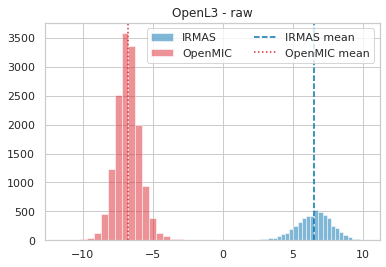

In [41]:
FEATURES = 'OpenL3'
plt.title(f'{FEATURES} - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

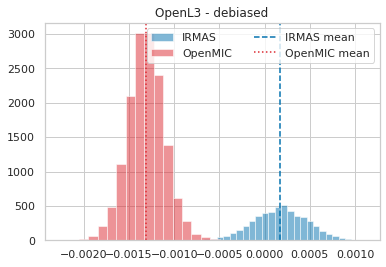

In [42]:
plt.title(f'{FEATURES} - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

## cosine similarity

In [43]:
# load the trained instrument classification model
file = open('models_irmas_openl3.pickle', 'rb')
inst_models_irmas = pickle.load(file)
file.close()

file = open('models_openmic_openl3.pickle', 'rb')
inst_models_openmic = pickle.load(file)
file.close()

print('Showing the pickled data:')
cnt = 0
for item in inst_models_irmas:
    print('Model ', cnt, ' is : ', item)
    cnt += 1

# compute cosine similarity between the dataset-separation LDA coef and the instrument Logistic Regression Classifier coef
cosine_sim_openl3_irmas = []
cosine_sim_openl3_openmic = []
for key in class_align:
    cosine_sim_openl3_irmas.append(cosine_similarity(inst_models_irmas[key].best_estimator_.coef_, LDA.coef_)[0][0])
    cosine_sim_openl3_openmic.append(cosine_similarity(inst_models_openmic[key].best_estimator_.coef_, LDA.coef_)[0][0])

print('Cosine similarity between dataset-separation and instrument classification using OpenL3:')
print('Trained on irmas: {}'.format(list(np.array(cosine_sim_openl3_irmas).round(2))))
print('Trained on openmic: {}'.format(list(np.array(cosine_sim_openl3_openmic).round(2))))

Showing the pickled data:
Model  0  is :  cello
Model  1  is :  clarinet
Model  2  is :  flute
Model  3  is :  guitar
Model  4  is :  organ
Model  5  is :  piano
Model  6  is :  saxophone
Model  7  is :  trumpet
Model  8  is :  violin
Model  9  is :  voice
Cosine similarity between dataset-separation and instrument classification using OpenL3:
Trained on irmas: [0.03, -0.04, -0.02, 0.02, -0.0, -0.03, 0.03, -0.01, 0.02, 0.0]
Trained on openmic: [0.0, -0.05, -0.05, -0.03, 0.0, 0.0, -0.05, -0.03, 0.03, 0.01]


# VGGish

In [44]:
embedding_name = 'vggish'

## Load embedding

In [45]:
#########################
# irmas: vggish embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(13410, 128) (13410,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 128) (6705,)


In [46]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [47]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [48]:
keys = [key[key.index('[')+1:key.index(']')] for key in key_clip]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [49]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
Y_ir = np.zeros(len(X_train))

print(X_train.shape, Y_ir.shape)

(5039, 128) (5039,)


In [50]:
#########################
# openmic: vggish embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

X = []

for key in tqdm(key_clip):
    X.append(np.mean(feature[keys[:]==key,:],axis=0))
    
X = np.array(X)
print(X.shape, key_clip.shape)

key_clip = np.array(key_clip)
key_clip

(180000, 128) (180000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [51]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [52]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [53]:
X_train = np.vstack((X_train, X[idx_train]))

Y_om = np.ones(len(X[idx_train]))
Y = np.hstack((Y_ir, Y_om))

## LDA

In [54]:
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X_train, Y)

v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

Xdeb = X_train.dot(np.eye(len(A)) - A)
Xsproj = LDA.transform(X_train)
Xdproj = LDA.transform(Xdeb)

In [55]:
with open('LDA_' + embedding_name + '_coef.pickle', 'wb') as fdesc:
    pickle.dump(LDA.coef_, fdesc)

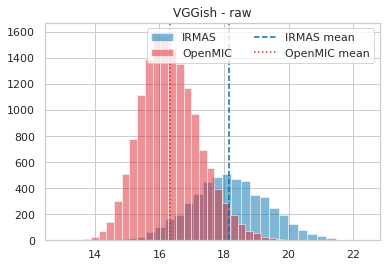

In [56]:
FEATURES = 'VGGish'
plt.title(f'{FEATURES} - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

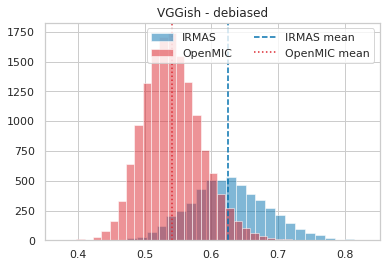

In [57]:
plt.title(f'{FEATURES} - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

## cosine similarity

In [58]:
# load the trained instrument classification model
file = open('models_irmas_vggish.pickle', 'rb')
inst_models_irmas = pickle.load(file)
file.close()

file = open('models_openmic_vggish.pickle', 'rb')
inst_models_openmic = pickle.load(file)
file.close()

print('Showing the pickled data:')
cnt = 0
for item in inst_models_irmas:
    print('Model ', cnt, ' is : ', item)
    cnt += 1

# compute cosine similarity between the dataset-separation LDA coef and the instrument Logistic Regression Classifier coef
cosine_sim_vggish_irmas = []
cosine_sim_vggish_openmic = []
for key in class_align:
    cosine_sim_vggish_irmas.append(cosine_similarity(inst_models_irmas[key].best_estimator_.coef_, LDA.coef_)[0][0])
    cosine_sim_vggish_openmic.append(cosine_similarity(inst_models_openmic[key].best_estimator_.coef_, LDA.coef_)[0][0])

print('Cosine similarity between dataset-separation and instrument classification using VGGish:')
print('Trained on irmas: {}'.format(list(np.array(cosine_sim_vggish_irmas).round(2))))
print('Trained on openmic: {}'.format(list(np.array(cosine_sim_vggish_openmic).round(2))))

Showing the pickled data:
Model  0  is :  cello
Model  1  is :  clarinet
Model  2  is :  flute
Model  3  is :  guitar
Model  4  is :  organ
Model  5  is :  piano
Model  6  is :  saxophone
Model  7  is :  trumpet
Model  8  is :  violin
Model  9  is :  voice
Cosine similarity between dataset-separation and instrument classification using VGGish:
Trained on irmas: [-0.09, -0.04, 0.09, -0.08, -0.06, -0.03, -0.04, 0.03, -0.07, -0.07]
Trained on openmic: [0.05, 0.01, -0.02, 0.06, -0.27, 0.18, -0.01, 0.04, 0.21, -0.12]


In [59]:
# use a Pandas DataFrame to record cosine_similarity results and save into a csv file later
cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train_set': [],
                          'cosine_similarity': [],
                         })

cosine_sim['instrument'] = [key for key in class_align] * 4
cosine_sim['embedding'] = ['openl3'] * len(class_align) * 2 +  ['vggish'] * len(class_align) * 2
cosine_sim['train_set'] = ['irmas'] * len(class_align) +  ['openmic'] * len(class_align) + \
                            ['irmas'] * len(class_align) + ['openmic'] * len(class_align)
cosine_sim['cosine_similarity'] = cosine_sim_openl3_irmas + cosine_sim_openl3_openmic + \
                                    cosine_sim_vggish_irmas + cosine_sim_vggish_openmic

cosine_sim.to_csv('cosine_similarity.csv', index=False)
cosine_sim

,instrument,embedding,train_set,cosine_similarity
0,cello,openl3,irmas,0.027766
1,clarinet,openl3,irmas,-0.038727
2,flute,openl3,irmas,-0.022632
3,guitar,openl3,irmas,0.021069
4,organ,openl3,irmas,-0.000048
5,piano,openl3,irmas,-0.033095
6,saxophone,openl3,irmas,0.026126
7,trumpet,openl3,irmas,-0.006180
8,violin,openl3,irmas,0.019590
9,voice,openl3,irmas,0.002898


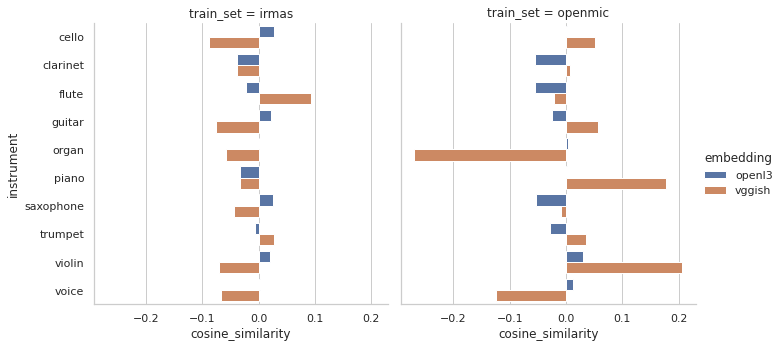

In [60]:
# save cosine similarity into a csv file
import seaborn as sns
import pandas as pd
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

df = pd.read_csv('cosine_similarity.csv')
sns.catplot(data=df, col='train_set', y='instrument', x='cosine_similarity', hue='embedding', kind='bar');
plt.savefig('cosine_similarity.png')

# YAMnet

In [61]:
embedding_name = 'yamnet'

## Load embedding

In [6]:
#########################
# irmas: vggish embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(33525, 1024) (33525,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 1024) (6705,)


In [7]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [8]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [9]:
keys = [key[key.index('[')+1:key.index(']')] for key in key_clip]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [10]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
Y_ir = np.zeros(len(X_train))

print(X_train.shape, Y_ir.shape)

(5039, 1024) (5039,)


In [11]:
#########################
# openmic: vggish embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

X = []

for key in tqdm(key_clip):
    X.append(np.mean(feature[keys[:]==key,:],axis=0))
    
X = np.array(X)
print(X.shape, key_clip.shape)

key_clip = np.array(key_clip)
key_clip

(380000, 1024) (380000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 1024) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [12]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [13]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [14]:
X_train = np.vstack((X_train, X[idx_train]))

Y_om = np.ones(len(X[idx_train]))
Y = np.hstack((Y_ir, Y_om))

## LDA

In [15]:
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X_train, Y)

v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

Xdeb = X_train.dot(np.eye(len(A)) - A)
Xsproj = LDA.transform(X_train)
Xdproj = LDA.transform(Xdeb)

In [16]:
with open('LDA_' + embedding_name + '_coef.pickle', 'wb') as fdesc:
    pickle.dump(LDA.coef_, fdesc)

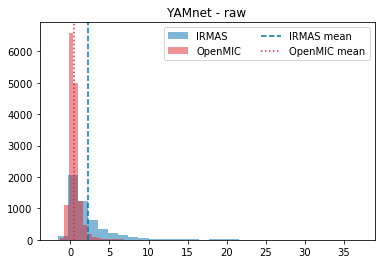

In [19]:
FEATURES = 'YAMnet'
plt.title(f'{FEATURES} - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

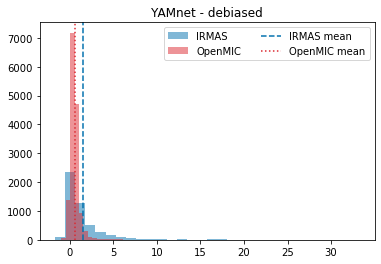

In [20]:
plt.title(f'{FEATURES} - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

## cosine similarity

In [21]:
# load the trained instrument classification model
file = open('models_irmas_yamnet.pickle', 'rb')
inst_models_irmas = pickle.load(file)
file.close()

file = open('models_openmic_yamnet.pickle', 'rb')
inst_models_openmic = pickle.load(file)
file.close()

print('Showing the pickled data:')
cnt = 0
for item in inst_models_irmas:
    print('Model ', cnt, ' is : ', item)
    cnt += 1

# compute cosine similarity between the dataset-separation LDA coef and the instrument Logistic Regression Classifier coef
cosine_sim_yamnet_irmas = []
cosine_sim_yamnet_openmic = []
for key in class_align:
    cosine_sim_yamnet_irmas.append(cosine_similarity(inst_models_irmas[key].best_estimator_.coef_, LDA.coef_)[0][0])
    cosine_sim_yamnet_openmic.append(cosine_similarity(inst_models_openmic[key].best_estimator_.coef_, LDA.coef_)[0][0])

print('Cosine similarity between dataset-separation and instrument classification using VGGish:')
print('Trained on irmas: {}'.format(list(np.array(cosine_sim_yamnet_irmas).round(2))))
print('Trained on openmic: {}'.format(list(np.array(cosine_sim_yamnet_openmic).round(2))))

Showing the pickled data:
Model  0  is :  cello
Model  1  is :  clarinet
Model  2  is :  flute
Model  3  is :  guitar
Model  4  is :  organ
Model  5  is :  piano
Model  6  is :  saxophone
Model  7  is :  trumpet
Model  8  is :  violin
Model  9  is :  voice
Cosine similarity between dataset-separation and instrument classification using VGGish:
Trained on irmas: [-0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.01, 0.01, 0.0, 0.0]
Trained on openmic: [-0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0]


In [65]:
# use a Pandas DataFrame to record cosine_similarity results and save into a csv file later
cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })

cosine_sim['instrument'] = [key for key in class_align] * 6
cosine_sim['embedding'] = ['openl3'] * len(class_align) * 2 +  ['vggish'] * len(class_align) * 2 + \
                            ['yamnet'] * len(class_align) * 2
cosine_sim['train set'] = ['irmas'] * len(class_align) +  ['openmic'] * len(class_align) + \
                            ['irmas'] * len(class_align) + ['openmic'] * len(class_align) + \
                            ['irmas'] * len(class_align) + ['openmic'] * len(class_align)
cosine_sim['cosine similarity'] = cosine_sim_openl3_irmas + cosine_sim_openl3_openmic + \
                                    cosine_sim_vggish_irmas + cosine_sim_vggish_openmic + \
                                        cosine_sim_yamnet_irmas + cosine_sim_yamnet_openmic

cosine_sim.to_csv('cosine_similarity.csv', index=False)
cosine_sim

,instrument,embedding,train set,cosine similarity
0,cello,openl3,irmas,0.027766
1,clarinet,openl3,irmas,-0.038727
2,flute,openl3,irmas,-0.022632
3,guitar,openl3,irmas,0.021069
4,organ,openl3,irmas,-0.000048
5,piano,openl3,irmas,-0.033095
6,saxophone,openl3,irmas,0.026126
7,trumpet,openl3,irmas,-0.006180
8,violin,openl3,irmas,0.019590
9,voice,openl3,irmas,0.002898


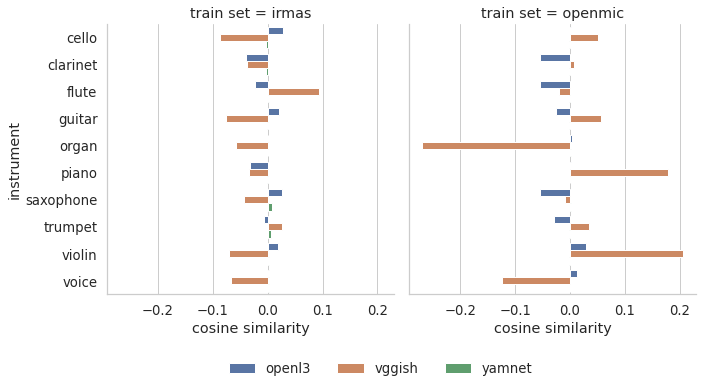

In [135]:
# save cosine similarity into a csv file
import seaborn as sns
import pandas as pd
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font_scale=1.2)

df = pd.read_csv('cosine_similarity.csv')
ax = sns.catplot(data=df, col='train set', y='instrument', x='cosine similarity', hue='embedding', kind='bar', aspect=12/12, 
               legend_out=False);
# g.fig.get_axes()[1].legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g._legend.set_bbox_to_anchor((2.5, 0.5))
# g.fig.get_axes()[1].legend(loc='lower right')
# plt.legend(loc='lower right')
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -0.1), ncol=3, title=None, frameon=False)
# plt.tight_layout()
plt.savefig('cosine_similarity.png', bbox_inches='tight')